# Proposed format

References:
* book: https://www.ryerson.ca/mining-complex-networks
* notebooks: https://github.com/ftheberge/GraphMiningNotebooks
    
**Part 1: EDA**

- 1.1 Relational data as graphs
    - basic igraph commands, main dataset, types of graphs
- 1.2 Exploratory data analysis (EDA)
    - degree, paths, connected components
- 1.3 Node importance: 
    - coreness, centrality, betweenness

**Part 2: Clustering**

- 2.1 Random graph models and benchmarks (ex: Erdos-Renyi, ABCD)
- 2.2 Transitivity
    - triangles and other motifs, local and global clustering coefficients, cliques
- 2.3 Clustering: modularity, Louvain, Leiden, ECG and properties; other methods
    - illustrations on various graphs; measures of cluster quality; ego-nets vs clusters
- 2.4 Extra module: Anomaly detection
    - illustration with football dataset

Some **igraph** references:
* https://igraph.readthedocs.io/en/0.10.2/
* https://towardsdatascience.com/newbies-guide-to-python-igraph-4e51689c35b4


## Required packages

* Minimal conda environment

```
conda create --name shortcourse python=3.7.9 numpy pandas jupyter matplotlib pycairo scikit-learn
source activate shortcourse
pip install igraph
pip install partition-igraph

python -m ipykernel install --user --name=shortcourse ## add to Jupyter

```

* Caveat: igraph is NOT the best tool for graph visualization, there are more specialized tool for this such as Graphviz, Bokeh, etc. However, igraph is a very powerful tool for graph analysis, is scalable (C background) and has R, Python and now Mathematica interfaces. We will use viz mainly to illustrate some concepts.

In [1]:
## path to the datasets
datadir='./Datasets/'

## required packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import igraph as ig
import partition_igraph
from collections import Counter
from sklearn.metrics import adjusted_rand_score as ARI
from sklearn.metrics import adjusted_mutual_info_score as AMI


# Part 1 - Basic Concepts and Exploratory Data Analysis (EDA)


## 1.1 Relational data as graphs

We will use the open source US airport graph as our main dataset:

* 2008 air traffic in the USA
* 464 nodes representing airports
* 12,000 edges representing travel from airport A to airport B, weighted by number of passengers 
* Some extra node attributes (city, state, lat/lon)
* Open access data

Some initial questions to ask when looking at (pairwise) relational data:
* is there a sense of **direction** to the relationship? (directed vs undirected graphs)
    * ex: direction of travel from airport A to B, I follow you vs. we are friends

* are some ties **stronger** than others? This is usually modelled in one of two ways:
  * **weights**: higher weights can mean stronger ties (ex: number of passengers; number of common friends);
  * **distance**: smaller distance can mean stronger ties (ex: distance between airports; commute time between cities; resistance in an electric circuit)

* can there be a relationship with oneself? This is modelled by edges from a node back to **itself**. (loops vs simple graphs)
  * ex: XXX add one

* are there other **attributes**? This can either be of the nodes or the edges.
  * ex: city, state as a node attributes

In [2]:
## read edges from csv file
D = pd.read_csv(datadir + 'Airports/connections.csv')
D.head() ## look at a few edges

,orig_airport,dest_airport,total_passengers
0,SFO,LAX,1442105
1,LAX,SFO,1438639
2,MCO,ATL,1436625
3,ATL,MCO,1424069
4,LAX,JFK,1277731


### Build a weighted directed graph from the edges

One way to create a (directed) graph in igraph is by handing it a list of edges in tuples of the form `(source, target, weight)`. We'll convert the above dataframe to a list of tuples and create a directed, weighted graph from it. 

In [3]:
tuple_list = [tuple(x) for x in D.values]
g = ig.Graph.TupleList(tuple_list, directed=True, edge_attrs=['weight'])

### Graph Objects in igraph

A graph in igraph consists of:
* a **vertex** sequence object, with 0-based indices
* an **edge** sequence object, each connecting a 2-ple of vertices

Note: nodes and vertices mean the same thing. igraph uses the language of vertices and we will use node and vertex interchangeably.

**WARNING**: node names, if stored, can also be integers and may not correspond to node indices.


### Vertices

In [4]:
## get a vertex by index (NOT the same thing as accessing the vertex by the name)
g.vs[0]

igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 0, {'name': 'SFO'})

In [5]:
## find a vertex given its name (be careful if names are also integers!)
g.vs.find('LAX')

igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 1, {'name': 'LAX'})

In [6]:
## find a vertex index given its name
g.vs.find('LAX').index

1

In [7]:
## listing vertices (showing top 5)
[v for v in g.vs][:5]

[igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 0, {'name': 'SFO'}),
 igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 1, {'name': 'LAX'}),
 igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 2, {'name': 'MCO'}),
 igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 3, {'name': 'ATL'}),
 igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 4, {'name': 'JFK'})]

Any vertex attribute may be added. In this case, the vertex set is used as a dictionary where the keys are the
attribute names. The values corresponding to the keys are the values of the given attribute for every vertex selected by the sequence. 

In [8]:
g.vs[0]['color'] = ['fuscia']
[v for v in g.vs][:5]

[igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 0, {'name': 'SFO', 'color': ['fuscia']}),
 igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 1, {'name': 'LAX', 'color': None}),
 igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 2, {'name': 'MCO', 'color': None}),
 igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 3, {'name': 'ATL', 'color': None}),
 igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 4, {'name': 'JFK', 'color': None})]

If you specify a sequence that is shorter than the number of vertices in
vertex sequence, the sequence is reused:

In [27]:
g.vs['color'] = ['lightblue', 'pink', 'purple']
[v for v in g.vs][:5]

[igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 0, {'name': 'SFO', 'color': 'lightblue'}),
 igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 1, {'name': 'LAX', 'color': 'pink'}),
 igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 2, {'name': 'MCO', 'color': 'purple'}),
 igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 3, {'name': 'ATL', 'color': 'lightblue'}),
 igraph.Vertex(<igraph.Graph object at 0x7ffc2c62b490>, 4, {'name': 'JFK', 'color': 'pink'})]

Number of vertices

In [10]:
g.vcount(), g.vcount() == len(g.vs)

(464, True)

### Edges

In [11]:
## get an edge by index in the edge sequence
g.es[0]

igraph.Edge(<igraph.Graph object at 0x7ffc2c62b490>, 0, {'weight': 1442105})

In [12]:
## edges have a 2-ple of vertices of an edge representing `(source, target)` nodes
g.es[0].tuple

(0, 1)

In [13]:
g.es[0].source, g.es[0].target

(0, 1)

The edge source and target vertices refer to the index of the source an target in the vertex sequence. Let's look up the details of the edge. 

In [14]:
e_idx = 0

source_idx = g.es[e_idx].tuple[0]
target_idx = g.es[e_idx].tuple[1]

source_name = g.vs[source_idx]['name']
target_name = g.vs[target_idx]['name']
edge_weight = g.es[e_idx]['weight']

print(source_name, '--->' ,target_name,'has weight',edge_weight)

SFO ---> LAX has weight 1442105


In [15]:
# package this in a function
def print_edge_details(e_idx):
    print(g.vs[g.es[e_idx].tuple[0]]['name'],'--->',g.vs[g.es[e_idx].tuple[1]]['name'],'has weight',g.es[e_idx]['weight'])

In [16]:
## is there an edge in the other direction? Look up an edge by vertex ids.
rev_e_idx = g.get_eid(target_idx, source_idx)
rev_e_idx

1

In [17]:
print_edge_details(rev_e_idx)

LAX ---> SFO has weight 1438639


Number of edges

In [18]:
g.ecount(), g.ecount() == len(g.es)

(12000, True)

It's easy to check if there is a way to get from one airport to another. This is like asking if the nodes are **connected**, that is, is there a path of edges between them. 

In [19]:
## sanity check if SFO and LAX are connected. We know this to be true already.
g.are_connected(0,1)

True

In [20]:
# We'll see later that we can't get from BMI to SFO. 
g.vs.find('BMI').index

100

In [21]:
g.are_connected(0, 100)

False

What if we want to find all routes orignating from SFO? We can do this by asking which edges are **incident**.

In [22]:
## list of all edges a given vertex is incident on
len(g.incident(0, mode='out'))

102

There are a lot. Let's see what a few of them are. 

In [23]:
n = 5
for e_idx in  g.incident(0, mode='out')[:n]:
    print_edge_details(e_idx)

SFO ---> SFO has weight 272
SFO ---> LAX has weight 1442105
SFO ---> MCO has weight 56437
SFO ---> ATL has weight 543811
SFO ---> JFK has weight 1000733


### Subgraphs and different types of graphs
To make our next analysis easier, we'll work off of a small subgraph.

In [24]:
subgraph_nodes = [g.vs.find(name='LAX').index,
                  g.vs.find(name='SFO').index,
                  g.vs.find(name='OAK').index]
subgraph_nodes

[1, 0, 38]

In [25]:
# induced subgraph from the list of nodes
sg = g.subgraph(subgraph_nodes)

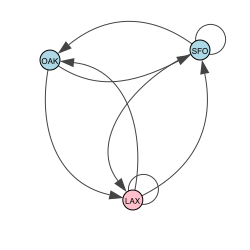

In [28]:
ig.plot(sg, bbox=(250,250), vertex_label=sg.vs['name'], 
        vertex_label_size=8, margin=50)

What if we want to know how many people travelled between the airports? In this case we don't care about the direction. We can do this by creating an undirected weighted graph, where the new weight are the summed edge weights from before.

In [29]:
undirected_sg = sg.as_undirected(combine_edges=sum)

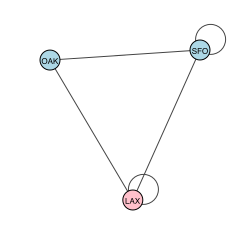

In [31]:
ig.plot(undirected_sg, bbox=(250,250), vertex_label=sg.vs['name'], 
        vertex_label_size=8, margin=50)


If we want to get rid of the loops, we can use `simplify`.

In [32]:
sg = sg.simplify(combine_edges=sum)

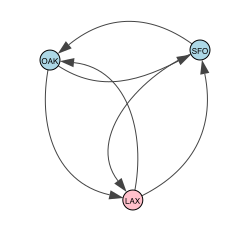

In [33]:
ig.plot(sg, bbox=(250,250), vertex_label=sg.vs['name'], 
        vertex_label_size=8, margin=50)

Combining the above, we get a simple, undirected graph. 

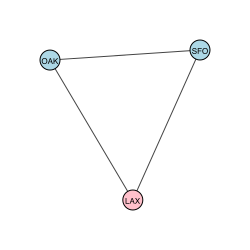

In [34]:
ig.plot(sg.as_undirected(combine_edges=sum),bbox=(250,250), vertex_label=sg.vs['name'], 
        vertex_label_size=8, margin=50)


The operations of `simplify` and `as_undirected` are non-descructive. But we redefined `sg` as the simple version above. `sg` is now a simple, directed graph. 

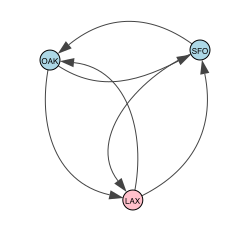

In [38]:
ig.plot(sg, bbox=(250,250), vertex_label=sg.vs['name'], 
        vertex_label_size=8, margin=50)

We've been carrying the weights through, so let's visualize them by setting an edge width attribute. 

In [41]:
sg.es['width'] = [int(np.log10(x)+1) for x in sg.es['weight']]

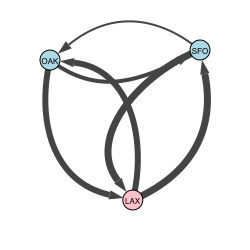

In [42]:
## Weighted digraph
ig.plot(sg, bbox=(250,250), vertex_label=sg.vs['name'], 
        vertex_label_size=8, margin=50)

### Plotting in igraph

* igraph uses **cairo** for plotting, along with a python interface such as **pycairo** or **cairocffi**.
* latest versions if igraph can also use **matplotlib** (see example below)
* graph can be exported as **networkx** format which can be used in **bokeh** for interactive plotting
* another options is to save the graph in DOT format used in **GraphViz**


In [ ]:
## using matplotlib - here with multiple plots
fig, ((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2, figsize=(8,8))
sg = g.subgraph(nodes)
ig.plot(sg.as_undirected(combine_edges=sum), bbox=(250,250), vertex_label=sg.vs['name'], 
        vertex_label_size=8, margin=50, target=ax1)
sg = sg.simplify(combine_edges=sum)
ig.plot(sg.as_undirected(combine_edges=sum),bbox=(250,250), vertex_label=sg.vs['name'], 
        vertex_label_size=8, margin=50, target=ax2)
ig.plot(sg, bbox=(250,250), vertex_label=sg.vs['name'], 
        vertex_label_size=6, margin=50, target=ax3)
sg.es['width'] = [int(np.log10(x)+1) for x in sg.es['weight']]
ig.plot(sg, bbox=(250,250), vertex_label=sg.vs['name'], 
        vertex_label_size=6, margin=50, target=ax4);

In [ ]:
## graph as list of edges 
df = pd.DataFrame()
df['from'] = [sg.vs[e.tuple[0]]['name'] for e in sg.es]
df['to'] = [sg.vs[e.tuple[1]]['name'] for e in sg.es]
df['volume'] = [e['weight'] for e in sg.es]
df.sort_values(by='volume', ascending=False, inplace=True)
df

In [ ]:
## graph as adjacency matrix
print(sg.get_adjacency())

In [ ]:
## graph as (weighted) adjacency matrix
print(sg.get_adjacency(attribute='weight'))

### attributes

* common **edge attribute** is the edge weight, or distance
* for the airport dataset, we also have a few node attributes
 * city and state
 * latitude and longitude (useful for nice layout)

In [ ]:
## read node attributes and add to graph
A = pd.read_csv(datadir+'Airports/airports_loc.csv')
A.head()

In [ ]:
## we have attribute by vertex name -- map to proper indices
lookup = {k:v for v,k in enumerate(A['airport'])}
l = [lookup[x] for x in g.vs()['name']]

## example
v = 0
print('vertex',v,':',g.vs[v]['name'], 'is at row', l[v])
A.loc[l[v]]

In [ ]:
## store attributes in graph
## nb: we use negative latitude for layout due to location of origin
g.vs['layout'] = [(A['lon'][i],-A['lat'][i]) for i in l]
g.vs['state'] = [A['state'][i] for i in l]
g.vs['city'] = [A['city'][i] for i in l]


In [ ]:
## let's look at one vertex
g.vs[0]

### Questions

* how many airports are in California (CA)?
* which states have the most airports? the least?
* which airport is the southernmost? northernmost?
* how many connection have at least 1 million passengers?


In [ ]:
## airports in CA, three ways
print('airports in CA:', len([v for v in g.vs if v['state'] == 'CA']), 
      sum([v['state']=='CA' for v in g.vs]),
      sum(A['state']=='CA'))

## states with most airports
print('\nmost airports:',Counter(g.vs['state']).most_common(5))

## states with the least airports
print('\nleast airports:',Counter(g.vs['state']).most_common()[-5:])

## north/south
latitude = [-x[1] for x in g.vs['layout']]
v = np.argmin(latitude)
print('\nsouthernmost:',g.vs[v],'\n')
v = np.argmax(latitude)
print('northernmost:',g.vs[v])

## 1M+ connections
print('\n1M+ connections:',len([e for e in g.es if e['weight'] >= 1000000]))

## 1.2 Exploratory Data Analysis (EDA)

### discussion

What makes network/graph data challenging?

* The points are connected and can therefore not be considered as independent samples
* Inference on graphs requires the topological structure: node, edge, neighbourhoods, etc.
* The node's topological roles can be highly variable (degree, betweenness, centrality, etc.)


### visualization

* Using a **force directed layout**, we see a small **disconnected component**, this is not uncommon;

* In social networks and many other types of graphs, a common situation is to have a **giant component** with most nodes, and some small components.

* Using the lat/lon based layout reveals a familiar shape


In [ ]:
ig.plot(g, vertex_size=5, edge_arrow_size=.5, edge_color='grey', 
        layout=g.layout_fruchterman_reingold(), bbox=(500,400))

In [ ]:
## lat/lon based layout
ig.plot(g, vertex_size=5, edge_arrow_size=.5, edge_color='grey', 
        layout=g.vs['layout'], bbox=(500,400))

In [ ]:
## we can zoom in on a single state
sg = g.subgraph([v for v in g.vs if v['state']=='MN'])
ig.plot(sg,bbox=(450,350), vertex_label=sg.vs['name'], vertex_size=15,layout=sg.vs['layout'],
            vertex_label_size=6, margin=50)

### Node degree(s)

A key node feature is their **degree**.

With a **directed graph**, we can distinguish 4 concepts of degree (!)

* in-degree: number of edges coming in
* out-degree: number of edges going out
* total degree: sum of the above 2 quantities
* (undirected) degree: degree when reducing to **undirected** graph


In [ ]:
## computing node degree ... in 4 different ways!
d = pd.DataFrame()
d['node'] = g.vs['name']
d['in-deg'] = g.degree(mode='in')
d['out-deg'] = g.degree(mode='out')
d['total-deg'] = g.degree(mode='all')
d['und-deg'] = g.as_undirected().degree()
d.loc[d['node'].isin(['SFO','LAX','OAK','OPF'])]

In [ ]:
## Ego-net of a node: subgraph induced by a node and its neighbours
## OPF's ego-net - Miami executive airport
sg = g.induced_subgraph(g.neighborhood(g.vs.find(name='OPF')))
ig.plot(sg, bbox=(300,300), vertex_label=sg.vs['name'], 
            vertex_label_size=8, margin=50)

In [ ]:
## undirected
sg = sg.as_undirected()
ig.plot(sg, bbox=(300,300), vertex_label=sg.vs['name'], 
            vertex_label_size=8, vertex_color='lightblue', margin=50)

### Weighted degree a.k.a. Strength

With **weighted** graphs, we also define:

* in-strength: sum of weights of all incoming edges
* out-strength: sum of weights of all outgoing edges
* total-strength: sum of the above two quantities

When converting a directed graph to undirected, it is common to add the edge weights, so we get the "total-strength".


In [ ]:
d['in-str'] = g.strength(mode='in', weights='weight')
d['out-str'] = g.strength(mode='out', weights='weight')
d['total-str'] = g.strength(mode='all', weights='weight')
## undirected graph, summing the edge weights
d['und-str'] = g.as_undirected(combine_edges=sum).strength(weights='weight')
d.loc[d['node'].isin(['SFO','LAX','OAK','OPF'])]

### degree distribution

Also common in most social-type networks, degree distribution is far from uniform in the airport graph, with lots of low degree nodes, and a small number of high degree ones.

This is indicative of **power-law** degree distribution.

In such networks, shortest paths between connected nodes are typically short (the **6-degree of separation** phenomenon).

In [ ]:
plt.figure(figsize=(8,3))
plt.subplot(121)
plt.hist(g.degree(mode='in'), bins=30)
plt.title('in-degree')
plt.xlabel('degree')
plt.ylabel('frequency')
plt.subplot(122)
plt.hist(g.degree(mode='out'), bins=30)
plt.title('out-degree')
plt.xlabel('degree');


### paths and connected components

* A **path** is a sequence of edges connecting two nodes
* In a **connected component**, there is a path between every pair of nodes
* Path length is usually the number of edges (**hop count**), but weights can also be considered
* For directed graphs, we can take directionality into account (**strong** connectivity) or not (**weak** connectivity); those are the same in undirected graphs


In [ ]:
print('strong connectivity:',g.connected_components(mode='strong').summary())
print('weak connectivity:',g.connected_components(mode='weak').summary())

## let's save an undirected version of the airport graph
g_und = g.as_undirected(combine_edges=sum) ## undirected graph, summing the weights
print('undirected connectivity:',g_und.connected_components().summary())

In [ ]:
## shortest (directed) paths
print('number of airports:',g.vcount())
for ap in ["OPF","SFO"]:
    print("\nlooking at:",ap)
    v = g.vs.find(name=ap)
    sp = g.distances(source=v, mode='out')[0]
    print('number of "unreacheable" airports:',sum([i == np.inf for i in sp]))
    print('mean number of hops to other airports:',np.mean([i for i in sp if i != np.inf ]))
    print('max number of hops to other airports:',np.max([i for i in sp if i != np.inf ]))


###  why are some airports "unreacheable"?

 * 2 airports are in a separate (weak) connected component;
 * what about the other 18?

In [ ]:
## color unreacheable nodes in red
for j in np.where([i == np.inf for i in sp]):
    g.vs[j]['color'] = 'red' 
    

In [ ]:
ig.plot(g, vertex_size=5, edge_arrow_size=.5, edge_color='grey', 
        layout=g.layout_fruchterman_reingold(), bbox=(500,400))

In [ ]:
## 2 airports in small connected component 
g.vs['cc'] = g.connected_components('weak').membership
print(Counter(g.vs['cc']))


In [ ]:
## let's remove those 2
v_list = [v['name'] for v in g.vs if v['cc']==1]
g_copy = g.copy()
g_copy.delete_vertices(v_list)


In [ ]:
## also remove airports w/o incoming links
v_list = [v for v in g_copy.vs if g_copy.degree(v,'in')==0]
print('removing',len(v_list),'more')
g_copy.delete_vertices(v_list)


In [ ]:
## still one left
ig.plot(g_copy, vertex_size=5, edge_arrow_size=.5, edge_color='grey', 
        layout=g_copy.layout_fruchterman_reingold(), bbox=(500,400))

In [ ]:
## recursively remove airports w/o incoming links
v_list = [v for v in g_copy.vs if g_copy.degree(v,'in')==0]
print('removing',len(v_list),'more')
g_copy.delete_vertices(v_list)


In [ ]:
## ignoring directionality
print('number of airports:',g.vcount())
for ap in ["SFO","OPF"]:
    print("\nlooking at:",ap)
    v = g.vs.find(name=ap)
    sp = g.distances(source=v, mode='all')
    print('number of unreacheable airports:',sum([i == np.inf for i in sp[0]]))
    print('mean number of hops to other airports:',np.mean([i for i in sp[0] if i != np.inf ]))
    print('max number of hops to other airports:',np.max([i for i in sp[0] if i != np.inf ]))


### questions

* which route is the busiest one-way? both ways?
* which airport has the largest number of outgoing connections? incoming? total?
* which airport has the largest number of incoming/outgoing/total passengers? the smallest?


In [ ]:
## busiest route (1-way) 
e = np.argmax(g.es['weight'])
print('1-way:',g.vs[g.es[e].tuple[0]]['name'], '---', g.es[e]['weight'], '-->', g.vs[g.es[e].tuple[1]]['name'], )

## busiest route (2-way) 
e = np.argmax(g_und.es['weight'])
print('2-way:', g_und.vs[g_und.es[e].tuple[0]]['name'], '---',  g_und.es[e]['weight'], '---', 
      g_und.vs[g_und.es[e].tuple[1]]['name'],)

## outgoing connections
x = np.argwhere(g.degree(mode='out') == np.max(g.degree(mode='out'))).flatten()
for v in x:
    print(g.vs[v]['name'],"has outgoing connections to",g.degree(v,'out'),"airports")

## incoming connections
x = np.argwhere(g.degree(mode='in') == np.max(g.degree(mode='in'))).flatten()
for v in x:
    print(g.vs[v]['name'],"has incoming connections from",g.degree(v,'in'),"airports")

## any connections
x = np.argwhere(g_und.degree() == np.max(g_und.degree())).flatten()
for v in x:
    print(g_und.vs[v]['name'],"has connections with",g_und.degree(v),"airports")

## largest number of passengers - outgoing
v = np.argmax(g.strength(mode='out', weights='weight'))
print(g.vs[v]['name'],"has",g.strength(v,'out', weights='weight'),"outgoing passengers")

## largest number of passengers - incoming
v = np.argmax(g.strength(mode='in', weights='weight'))
print(g.vs[v]['name'],"has",g.strength(v,'in', weights='weight'),"incoming passengers")

## largest number of passengers - total
v = np.argmax(g_und.strength(weights='weight'))
print(g_und.vs[v]['name'],"has",g.strength(v, weights='weight'),"total passengers")

## smallest number of passengers - total
v = np.argmin(g_und.strength(weights='weight'))
print(g_und.vs[v]['name'],"has",g.strength(v, weights='weight'),"total passengers")


## 1.3 Node importance


### Coreness (k-cores)

The **k-core** of a graph is the maximal subgraph where all nodes have degree at least k. The **coreness** of a node is k if it belongs to the k-core, but not the (k+1)-core. 

This is usually done with the **un-directed** degrees, but one can also look for 'in' and 'out' k-cores.

Below we compute coreness for the undirected version of the airport graph. We see:

* many nodes in large 50-core subgraph (which we plot)
* many nodes with small coreness (1 or 2)

Pruning nodes with small coreness often drastically reduces the size of the graph.

In [ ]:
## let's drop loops from undiredcted graph
g_und = g_und.simplify(combine_edges=sum)

## most frequent coreness values
g_und.vs['core'] = g_und.coreness()
Counter(g_und.vs['core']).most_common(3)

In [ ]:
plt.hist(g_und.vs['core'], bins=25);

In [ ]:
## largest k-core - plot with lat/lon layout
sg = g_und.subgraph([v for v in g_und.vs if v['core']==50])
ig.plot(sg,bbox=(600,450), vertex_label=sg.vs['name'], vertex_size=15,layout=sg.vs['layout'],
            vertex_label_size=6, margin=50)

## Centrality, betweenness

There are various ways to define the most **important** nodes in a network.
Two families of measures are:

* Node **centrality**, which includes measures such as **degree** and **pagerank**.
 * those measure overall connectedness in various ways
* **Betweenness** measures the proportion of shortest paths going through some node or edge.


In [ ]:
## Centrality and nodes betweenness - undirected airport graph
df = pd.DataFrame()
df['degree'] = g_und.degree()
df['pagerank'] = g_und.pagerank(weights='weight')
n = g_und.vcount()
df['between'] = [2*x/((n-1)*(n-2)) for x in g_und.betweenness()] ## normalized
df['state'] = g_und.vs['state']
df['city'] = g_und.vs['city']
df['name'] = g_und.vs['name']
df.sort_values(by='pagerank', inplace=True, ascending=False)
df.head()

In [ ]:
df.sort_values(by='between', inplace=True, ascending=False)
df.head()

In [ ]:
plt.scatter(df['degree'],df['pagerank'])
plt.xlabel('degree')
plt.ylabel('pagerank');

In [ ]:
plt.scatter(df['degree'],df['between'])
plt.xlabel('degree')
plt.ylabel('betweenness');

### questions

* there is one node with low degree but betweenness above 0.02
  * which node is it?
  * what could explain this?


In [ ]:
## low degree, high betweenness node
print(df.loc[ (df['degree']<25) & (df['between']>.02)])

## look at its ego-net ... along with edge weights
v = g_und.vs.find('LSV')
sg = g_und.subgraph(g_und.neighborhood(v))
ig.plot(sg,bbox=(600,400), vertex_label=sg.vs['name'], vertex_size=15,layout=sg.vs['layout'],
            vertex_label_size=6, margin=50, edge_label=sg.es['weight'])


# extra questions - a different graph

The airport graph, as well as most social type graphs, have some common structure: 
* **power-law** degree distribution
* **small world** behaviour (a.k.a. 6-degree of separation)
    
In the 'Example' subdirectory of the datasets, there are two files:
* edges: 2-ples, undirected, unweighted edges (no header)
* nodes: csv file with node attributes (with header)

Beware: node names are integers

Follow the steps:

* build an undirected, unweighed graph using the 'edges' file and remove loops; how many nodes/edges are there?
* plot a histogram of the degree distribution
* find mean/max path lengths from a few nodes to all nodes
* from the results of the previous 2 tests ... what do you think this graph could be?
* load the node attributes, which include lat/lon, use those to plot the graph, what now?


In [ ]:
## read edge list and build undirected simple graph
gr = ig.Graph.Read_Ncol(datadir+'Example/edges', directed=False, )
gr = gr.simplify()
print(gr.vcount(), 'nodes and',gr.ecount(),'edges')
print(gr.vs[0])

In [ ]:
## degrees - mostly small values ...
print('max:',np.max(gr.degree()))
plt.hist(gr.degree(), bins=16);

In [ ]:
## shortest paths for some a few node(s) -- much larger values than the airport graph ...
print('number of nodes:',gr.vcount())
for v in [0,1000]:
    print("\nlooking at node:",v)
    sp = gr.distances(source=v)
    print('number of unreacheable nodes:',sum([i == np.inf for i in sp[0]]))
    print('mean number of hops to other nodes:',np.mean([i for i in sp[0] if i != np.inf ]))
    print('max number of hops to other nodes:',np.max([i for i in sp[0] if i != np.inf ]))


In [ ]:
## read node attributes
X = pd.read_csv(datadir+'Example/nodes')
X.head()

In [ ]:
## we have attribute by vertex name -- map to proper indices
lookup = {str(k):v for v,k in enumerate(X['name'])}
l = [lookup[x] for x in gr.vs()['name']]

## store layout attributes in graph and plot
## nb: we use negative latitude for layout due to location of origin
gr.vs['layout'] = [(X['lon'][i],-X['lat'][i]) for i in l]
ig.plot(gr, bbox=(500,400), layout = gr.vs['layout'], vertex_size=3, vertex_color='lightblue', margin=50)


### Europe Electric Grid

Network of high voltage grid in Europe. Vertices are stations and edges are the lines connecting them.
More details at: https://zenodo.org/record/47317#.Xt6nzy3MxTY


In [ ]:
## clean up
del(g.vs['cc'])
del(g_und.vs['core'])
del(gr)

# Part 2 - Clustering

## 2.1 Random Graph Models

Random graph models are useful for various reasons:
* interpretation of results on real graphs (ex: is this value expected? high? low?)
* to compare algorithms (ex: clustering algorithms)
* to study theoretical properties

Usually, we fix some aspects of the graph, such as the **number of nodes**, and randomly sample.
There are many such models, including:
* Erdos-Renyi model: fix the number of nodes and randomly place edges
* Chung-Lu/Configuration models: as above, but given a degree distribution for the nodes
* Barabasi-Albert model: "the righ gets richer" model; a new node is more likely to link with a hub
* LFR, ABCD models: power-law node degree distribution with ground-truth communities


In [ ]:
## Erdos-Renyi graph with same number of nodes/edges as (undirected) airport graph
g_er = ig.Graph.Erdos_Renyi(n=g_und.vcount(), m=g_und.ecount())
print('min degree',np.min(g_er.degree()),'max degree',np.max(g_er.degree()))
ig.plot(g_er, vertex_size=5, vertex_color='lightblue', edge_color='grey', bbox=(500,400))

In [ ]:
## Configuration model: same degree sequence as airport graph
g_ds = ig.Graph.Degree_Sequence(g_und.degree())
print('min degree',np.min(g_ds.degree()),'max degree',np.max(g_ds.degree()))
ig.plot(g_ds, vertex_size=5, vertex_color='lightblue', edge_color='grey', bbox=(500,400))

## 2.2 Triangles and Transitivity

* Edges represent relations between entities (nodes) in graphs/networks.

* The next fundamental motifs are **triangles**

* The presence of triangles is indicative of communities (dense subgraph(s) in a graph)

* Two fundamental measures of the presence of triangles in graphs are:

    * **transitivity** (global clustering coefficients) measures the proportion of wedges (two-hop path in an undirected graph) that form a triangle
    * **local transitivity** (local clustering coefficient) for a node is the proportion of pairs of neighbours that form a triangle; we also define the **average local transitivity** by averaging over all nodes of degree at least 2.

Those measures assume **undirected** graphs.

While we can define triangles and other motifs for directed graphs, clustering generally assumes undirected graphs.

We compute the above for the airport graph, as we look for nodes with high/low local transitivity.

In [ ]:
## airport graph transitivity
print('trans:',g_und.transitivity_undirected())
print('avg local trans:',g_und.transitivity_avglocal_undirected())


In [ ]:
## local transitivity - nodes with degree < 2 will get 0
g_und.vs['trans'] = g_und.transitivity_local_undirected(mode='zero') 

## high transitivity
v = np.argmax(g_und.vs['trans'])
print('airport:',g_und.vs[v]['name'],', plotting its ego-net:')
sg = g_und.subgraph(g_und.neighborhood(v))
ig.plot(sg,bbox=(400,300), vertex_label=sg.vs['name'], vertex_size=15,layout=sg.vs['layout'],
            vertex_label_size=6, vertex_color='lightblue', margin=50)


In [ ]:
## transitivity for an ER graph
print('trans:',g_er.transitivity_undirected())
print('avg local trans:',g_er.transitivity_avglocal_undirected())


In [ ]:
## transitivity for random graph with the same degree sequence
print('trans:',g_ds.transitivity_undirected())
print('avg local trans:',g_ds.transitivity_avglocal_undirected())


### Cliques

Triangles are also known as **3-cliques**; 
a clique of size k is a fully connected subgraph with k nodes.

The **clique number** is the size of the largest clique.


In [ ]:
## cliques in the airport graph
print('number of 3-cliques:',len(g_und.cliques(min=3, max=3)))
print('number of 4-cliques:',len(g_und.cliques(min=4, max=4)))
print('max clique:',g_und.clique_number())

In [ ]:
## cliques in the ER graph
print('number of 3-cliques:',len(g_er.cliques(min=3, max=3)))
print('number of 4-cliques:',len(g_er.cliques(min=4, max=4)))
print('max clique:',g_er.clique_number())

In [ ]:
## cliques in the degree sequence graph
print('number of 3-cliques:',len(g_ds.cliques(min=3, max=3)))
print('number of 4-cliques:',len(g_ds.cliques(min=4, max=4)))
print('max clique:',g_ds.clique_number())

### directed graphs

Clique finding assumes undirected graphs (see below).

For directed graphs, there are 16 different possibilities for each **triad**

REF: "The Structure of Positive Interpersonal Relations in Small Groups (1967)"

The **triad census** function counts all occurrences, and returns the counts in a specific ordering:
* '003': no edge
* '012': 1 directed edge only
* '102': 2 directed edges in opposite direction between the same pair of nodes
* ...
* '300': all 6 directed edges are present.


In [ ]:
## 3-cliques on directed airport graph
len(g.cliques(min=3,max=3))

In [ ]:
## triads
tc = g.triad_census()
print('number of triads:',np.sum(tc))
print('by type:',tuple(tc))

### questions

* find the node in the undirected airport graph with degree 5 or more having the lowest transitivity; didn't we see that node before?
* which triad motif is the rarest in the (directed) airport graph? 


In [ ]:
## node with low transitivity, degree at least 5
x = np.argmin([v['trans'] for v in g_und.vs if g_und.degree(v)>=5])
v = [v for v in g_und.vs if g_und.degree(v)>=5][x]
print('airport:',v['name'],', plotting its ego-net:')
sg = g_und.subgraph(g_und.neighborhood(v))
ig.plot(sg,bbox=(400,300), vertex_label=sg.vs['name'], vertex_size=15,layout=sg.vs['layout'],
            vertex_label_size=6, vertex_color='lightblue', margin=50)

## Recall that LSV is also the node we found to have low degree/centrality, but relatively high betweenness


In [ ]:
## The rarest triad motif is the 10th, which is motif '030C', a cycle of directed edges.

## There are more node pairs with two edges than with a single edge.
print('number of edges:',g.ecount())
g.es['mark'] = 1
print(Counter(g.as_undirected(combine_edges=sum).es['mark']))
del(g.es['mark'])

In [ ]:
## clean-up
del(g_und.vs['trans'])

## 2.3 Clustering

Graph clustering, a.k.a. node partitioning, is a very active research area, with dozens of algorithms.
Some good ones are:

* Louvain (multilevel): 
    * modularity optimization 
    * suffers from resolution limit (may merge "natural" communities)
    * may return disconnected communities
    * fast
    * somewhat unstable for graphs with homogeneous edge weights
* Leiden:
    * Louvain-based
    * faster
    * communities are all connected
* ECG (ensemble clustering):
    * Louvain-based
    * better stability for graphs with homogeneous edge weights
    * less affected by resolution limit
* Infomap
    * based on information theory concepts: encoding random walks is shorter within communities
    * good results with low to moderate noise graphs
    * may not converge at all for noisy graphs
* Label Propagation
    * very fast
    * will not converge at all for noisy graphs

Measures of community strength include:
* modularity ("proportion of edges. within communities" - "expected proportion under null model")
* comparing degree within and between communities overall
* comarting degree within and between communities for each vertex

In [ ]:
## clustering the ER graph
ec = g_er.community_ecg()
print('number of communities:',np.max(ec.membership)+1)
print('modularity:',g_er.modularity(ec.membership))

## collapse communities - show degree between and within communities
g_er.es['label'] = 1
G = ec.cluster_graph(combine_edges=sum)
G.vs['label'] = [2*G.ecount() for G in ec.subgraphs()]
ig.plot(G, bbox=(400,300), vertex_label_size=8, edge_label_size=8)


### ABCD graphs to compare algorithms

This model generates graphs with power-law degree distribution and communities.

The strength of the communities is adjusted via a 'noise' parameter 'mu'.

Code is very fast (Julia): https://github.com/bkamins/ABCDGraphGenerator.jl

Even faster multi-thread version: https://github.com/tolcz/ABCDeGraphGenerator.jl

Generalizations in development:
* graphs with communities and outlier nodes
* hypergraphs

We'll look at two ABCD graphs, along with ground-truth communities:

* 1000 nodes, 14 communities, 1/3 'noise' edges (mu = 0.33)
* 1000 nodes, 14 communities, 2/3 'noise' edges (mu = 0.67)

### Comparing resulting communities

When ground truth is available, good measures to compare various clustering results are:
* Adjusted mutual information (AMI)
* Adjusted RAND index (ARI)
* Adjusted graph-aware RAND index (AGRI)

In [ ]:
def print_scores(g, clustering):
    print('Number of communities:', np.max(clustering.membership)+1)
    print('AMI:', AMI(g.vs['gt'],clustering.membership),
          '\tARI:', ARI(g.vs['gt'],clustering.membership),
          '\tAGRI:', partition_igraph.gam(g, {k:v['gt'] for k,v in enumerate(g.vs)}, clustering))
    print('modularity:', g.modularity(clustering.membership))

In [ ]:
mu = 33 ## 1/3 noise edges

## load edges, build graph
df = pd.read_csv(datadir+'ABCD/edges_'+str(mu)+'.dat', sep='\t', header=None)
abcd33 = ig.Graph.TupleList([tuple(x) for x in df.values], directed=False)

## load ground-truth communities - add as node attribute
df = pd.read_csv(datadir+'ABCD/communities_'+str(mu)+'.dat', sep='\t', header=None)
gt = dict([tuple(x) for x in df.values])
abcd33.vs['gt'] = [gt[x] for x in abcd33.vs['name']]

## try some algorithms
print('Number of ground-truth communities:', np.max(abcd33.vs['gt']),'\n')
print('Louvain:')
print_scores(abcd33, abcd33.community_multilevel())
print('\nLeiden:')
print_scores(abcd33, abcd33.community_leiden(objective_function='modularity'))
print('\nECG:')
print_scores(abcd33, abcd33.community_ecg())
print('\nInfomap:')
print_scores(abcd33, abcd33.community_infomap())
print('\nLabel Propagation:')
print_scores(abcd33, abcd33.community_label_propagation())

## color w.r.t. ground truth communities
nc = max(abcd33.vs['gt'])
pal = ig.ClusterColoringPalette(nc+1)
abcd33.vs['color'] = [pal.get(i) for i in abcd33.vs['gt']]
ly = abcd33.layout_fruchterman_reingold()
ig.plot(abcd33, layout=ly, vertex_size=5, bbox=(0,0,500,400), edge_color='lightgrey')


In [ ]:
## collapse communities - show degree between and within communities
ec = abcd33.community_ecg()
abcd33.es['label'] = 1
G = ec.cluster_graph(combine_edges={'label':sum})
G.vs['label'] = [2*G.ecount() for G in ec.subgraphs()]
del(abcd33.es['label']) ## clean up
ig.plot(G, bbox=(400,300), vertex_label_size=8, edge_label_size=8)

In [ ]:
mu = 67 ## 2/3 noise edges

## load edges, build graph
df = pd.read_csv(datadir+'ABCD/edges_'+str(mu)+'.dat', sep='\t', header=None)
abcd67 = ig.Graph.TupleList([tuple(x) for x in df.values], directed=False)

## load ground-truth communities - add as node attribute
df = pd.read_csv(datadir+'ABCD/communities_'+str(mu)+'.dat', sep='\t', header=None)
gt = dict([tuple(x) for x in df.values])
abcd67.vs['gt'] = [gt[x] for x in abcd67.vs['name']]

## try some algorithms
print('Number of ground-truth communities:', np.max(abcd67.vs['gt']),'\n')
print('Louvain:')
print_scores(abcd67, abcd67.community_multilevel())
print('\nLeiden:')
print_scores(abcd67, abcd67.community_leiden(objective_function='modularity'))
print('\nECG:')
print_scores(abcd67, abcd67.community_ecg())
print('\nInfomap:')
print_scores(abcd67, abcd67.community_infomap())
print('\nLabel Propagation:')
print_scores(abcd67, abcd67.community_label_propagation())

## color w.r.t. ground truth communities
nc = max(abcd67.vs['gt'])
pal = ig.ClusterColoringPalette(nc+1)
abcd67.vs['color'] = [pal.get(i) for i in abcd67.vs['gt']]
ly = abcd67.layout_fruchterman_reingold()
ig.plot(abcd67, layout=ly, vertex_size=5, bbox=(0,0,500,400), edge_color='lightgrey')


In [ ]:
## collapse communities - show degree between and within communities
ec = abcd67.community_ecg()
abcd67.es['label'] = 1
G = ec.cluster_graph(combine_edges={'label':sum})
G.vs['label'] = [2*G.ecount() for G in ec.subgraphs()]
del(abcd67.es['label']) ## clean up
ig.plot(G, bbox=(400,300), vertex_label_size=8, edge_label_size=8)

### clusters in the airport graph

In [ ]:
## Louvain algorithm is randomized - fix the seed to compare results
import random
random.seed(31416)

In [ ]:
## Louvain clusters (weighted graph)
ml = g_und.community_multilevel(weights='weight')
g_und.vs['ml'] = ml.membership
pal = ig.ClusterColoringPalette(n=np.max(ml.membership)+1)
g_und.vs['color'] = [pal.get(i) for i in ml.membership]

## lat/lon based layout
print('modularity:',g_und.modularity(ml.membership, weights='weight'))
ig.plot(g_und, vertex_size=5, edge_color='grey', layout=g.vs['layout'], bbox=(500,400))

In [ ]:
## collapse communities - show degree between and within communities
g_und.es['label'] = 1
g_und.vs['lat'] = [v['layout'][0] for v in g_und.vs]
g_und.vs['lon'] = [v['layout'][1] for v in g_und.vs]
G = ml.cluster_graph(combine_vertices={'lat':np.mean,'lon':np.mean}, combine_edges={'label':sum})
G.vs['label'] = [2*G.ecount() for G in ml.subgraphs()]
ly = [(v['lat'],v['lon']) for v in G.vs]
ig.plot(G, layout=ly, bbox=(450,350), vertex_label_size=8, edge_label_size=8, vertex_color='lightblue')

In [ ]:
## clean up
del(g_und.es['label'])
del(g_und.vs['lat'])
del(g_und.vs['lon'])

### ego-nets and communities

Suppose we want to look at node "near" some seed node $v$. One common way to do this is to look at its **ego-net**, i.e. the subgraph consisting of node $v$ and all other nodes that can be reached from $v$ in $k$ hops or less, where $k$ is small, typically 1 or 2. 

Such subgraphs can become large quickly as we increase $k$. In the cells below, we look at ego-nets and compare with another approach to extract subgraph(s) around $v$ via clustering.

We consider the undirected airport graph. We compare ego-nets (1 and 2-hops subgraphs from a given node) with clusters obtained via graph clustering for some vertex $v$ (you can try other vertices).

In [ ]:
## pick a vertex v (not too high degree to allow for easy viz)
v = g_und.vs.find('SCF').index
g_und.vs['color'] = 'lightblue'
g_und.vs[v]['color'] = 'black'

## show its ego-net for k=1 (vertex v in black)
sg = g_und.subgraph([i for i in g_und.neighborhood(v,order=1)])
print(sg.vcount(),'nodes',sg.ecount(),'edges')
ig.plot(sg,bbox=(0,0,300,300), vertex_size=8)

In [ ]:
## show the 2-core of its 2-hops ego-net ... this is already quite large!
sg = g_und.subgraph([i for i in g_und.neighborhood(v,order=2)])
sg.vs()['core'] = sg.coreness()
sg.delete_vertices([v for v in sg.vs if v['core']<2])
print(sg.vcount(),'nodes',sg.ecount(),'edges')
ig.plot(sg,bbox=(0,0,300,300), vertex_size=8, edge_color='lightgrey')

In [ ]:
## use Louvain clustering and show the 2-core of the cluster containing the selected vertex
m = g_und.vs[v]['ml']
sg = g_und.subgraph([i for i in range(g_und.vcount()) if ml.membership[i]==m])
sg.vs()['core'] = sg.coreness()
sg.delete_vertices([v for v in sg.vs if v['core']<2])
print(sg.vcount(),'nodes',sg.ecount(),'edges')
ig.plot(sg,bbox=(0,0,300,300), vertex_size=8, edge_color='lightgrey')

In [ ]:
## prune nodes 3+ hops away
v = sg.vs.find(color='black')
ssg = sg.subgraph([i for i in sg.neighborhood(v,order=2)])
ssg.vs()['core'] = ssg.coreness()
ssg.delete_vertices([v for v in ssg.vs if v['core']<2])
print(ssg.vcount(),'nodes',ssg.ecount(),'edges')
ig.plot(ssg,bbox=(0,0,300,300), vertex_size=8, edge_color='lightgrey')

### questions

for the airport (undirected) graph:
* what are the most frequent states in each of the Louvain clusters (ml) we found?
* find all nodes of degree at least 10 that have all of their neighbours in their own Louvain cluster


In [ ]:
## Louvain - most frequent states
for sg in ml.subgraphs():
    print('cluster:',sg.vcount(),'nodes, frequent states:',Counter(sg.vs['state']).most_common(5))
    
## store community and degree for each node for quick reference
g_und.vs['ml'] = ml.membership
g_und.vs['degree'] = g_und.degree()

## compute number of neighbours in same community for each node
for v in g_und.vs:
    if len(set([g_und.vs[w]['ml'] for w in g_und.neighborhood(v)])) == 1:
        if v['degree'] >= 10:
            print(v['name'],v['city'],v['state'],v['degree'])

In [ ]:
## clean-up
del(g_und.vs['ml'])
del(g_und.vs['degree'])

# To go further

More topics can be found in:
* book: https://www.ryerson.ca/mining-complex-networks
* notebooks: https://github.com/ftheberge/GraphMiningNotebooks
    
including:   
* more centrality measures
* clustering: overlapping clusters, outliers    
* degree assortativity
* vertex and graph embedding
* hypergraphs
* network robustness
* road networks


## 2.4 Extra module - community-based anomaly detection

### New dataset -- American College Football Graph

This is a nice, small graph for illustrating anomaly detection methods.

The graph consists of 115 US college football teams (nodes) playing games (edges).

Teams are part of 12 conferences (the 'communities'):
*   0 = Atlantic Coast
*   1 = Big East
*   2 = Big Ten
*   3 = Big Twelve
*   4 = Conference USA
*   5 = Independents
*   6 = Mid-American
*   7 = Mountain West
*   8 = Pacific Ten
*   9 = Southeastern
*  10 = Sun Belt
*  11 = Western Athletic

14 teams out of 115 appear as "anomalies", namely:
- the 5 teams in #5 conference (Independent) play teams in other conferences 
- the 7 teams in #10 conference (Sun Belt) are broken in 2 clumps 
- 2 teams from #11 conference play mainly with #10 conference

[REF]: "Community structure in social and biological networks", M. Girvan and M. E. J. Newman
PNAS June 11, 2002 99 (12) 7821-7826; https://doi.org/10.1073/pnas.122653799


In [ ]:
## read graph and communities
cfg = ig.Graph.Read_Ncol(datadir+'Football/football.edgelist',directed=False)
c = np.loadtxt(datadir+'Football/football.community',dtype='uint16',usecols=(0))
cfg.vs['community'] = [c[int(x['name'])] for x in cfg.vs]

## plot the College Football Graph
## show communities in different colors, anomalies as squares
cfg.vs['shape'] = 'circle'
cfg.vs['anomaly'] = 0
pal = ig.ClusterColoringPalette(n=max(cfg.vs['community'])+1) 
cfg.vs['color'] = [pal.get(int(i)) for i in cfg.vs['community']]
for v in cfg.vs:
    if v['community'] in [5,10] or v['name'] in ['28','58']:
        v['shape']='square'
        v['anomaly']=1
ly = cfg.layout_fruchterman_reingold()
ig.plot(cfg, layout=ly, bbox=(0,0,500,300), vertex_size=6, edge_color='lightgray')


In [ ]:
## participation coefficient - high value indicative of outlier
ec = cfg.community_ecg()
cfg.vs['ecg'] = ec.membership
for v in cfg.vs:
    l = list(Counter([cfg.vs[x]['ecg'] for x in cfg.neighbors(v)]).values()) ## neighbour's communities
    s = sum(l)
    v['pc'] = 1-sum([i**2/s**2 for i in l]) ## measures the homogeneity 
plt.rcParams['font.size'] = '14'
X = [v['pc'] for v in cfg.vs if v['anomaly']==0]
Y = [v['pc'] for v in cfg.vs if v['anomaly']==1]
plt.boxplot([X,Y],labels=['Regular','Outlier'],sym='.',whis=(0,100), widths=.5)
plt.ylabel('Participation coefficient',fontsize=14);

In [ ]:
## ECG: node strongly in a community has high ecg weights to neighbours
cfg.es['ecg_weight'] = ec.W
for v in cfg.vs:
    v['ecg'] = np.mean([cfg.es[e]['ecg_weight'] for e in cfg.incident(v)])
X = [v['ecg'] for v in cfg.vs if v['anomaly']==0]
Y = [v['ecg'] for v in cfg.vs if v['anomaly']==1]
plt.boxplot([X,Y],labels=['Regular','Outlier'],sym='.',whis=(0,100), widths=.5)
plt.ylabel('ECG weights',fontsize=14);
